# **导包**

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# **数据预处理**

In [2]:
# 读取数据集
df = pd.read_csv('patient.csv')

# 输出前五行数据
print("数据集的前五行：")
print(df.head())

数据集的前五行：
   Age  Gender  Total_Bilirubin  Direct_Bilirubin  Alkaline_Phosphotase  \
0   65  Female              0.7               0.1                   187   
1   62    Male             10.9               5.5                   699   
2   62    Male              7.3               4.1                   490   
3   58    Male              1.0               0.4                   182   
4   72    Male              3.9               2.0                   195   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Total_Protiens  \
0                        16                          18             6.8   
1                        64                         100             7.5   
2                        60                          68             7.0   
3                        14                          20             6.8   
4                        27                          59             7.3   

   Albumin  Albumin_and_Globulin_Ratio  Dataset  
0      3.3                        0.90 

In [3]:
# 检查是否有缺失值
print("\n缺失值检查：")
print(df.isnull().sum())

# 数据预处理
# 处理缺失值前查看缺失值
print("填充缺失值前：")
print(df['Albumin_and_Globulin_Ratio'].isnull().sum())

# 处理缺失值
#创建一个 SimpleImputer 对象，并指定填充策略为均值（mean）。这意味着将使用该列的均值填充所有的缺失值。
imputer = SimpleImputer(strategy='mean')
df['Albumin_and_Globulin_Ratio'] = imputer.fit_transform(df[['Albumin_and_Globulin_Ratio']])

# 处理缺失值后查看缺失值
print("填充缺失值后：")
print(df['Albumin_and_Globulin_Ratio'].isnull().sum())


缺失值检查：
Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64
填充缺失值前：
4
填充缺失值后：
0


In [4]:
# 编码分类变量 'Gender'
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})

# 特征和目标变量定义
X = df.drop(['Dataset'], axis=1)
y = df['Dataset'].map({1: 1, 2: 0})  # 映射为二分类 (1 为肝病, 0 为非肝病)

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **数据可视化**

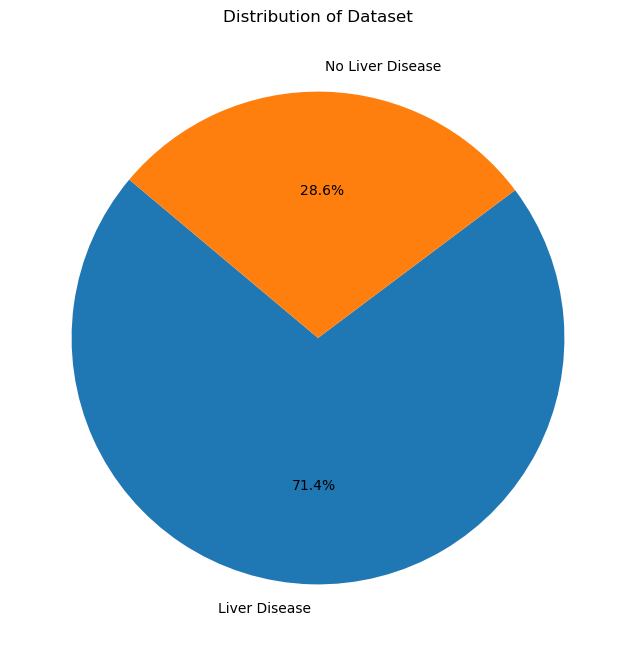

In [5]:
# 绘制 Dataset 的饼状图
dataset_counts = df['Dataset'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(dataset_counts, labels=['Liver Disease', 'No Liver Disease'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Dataset')
plt.show()

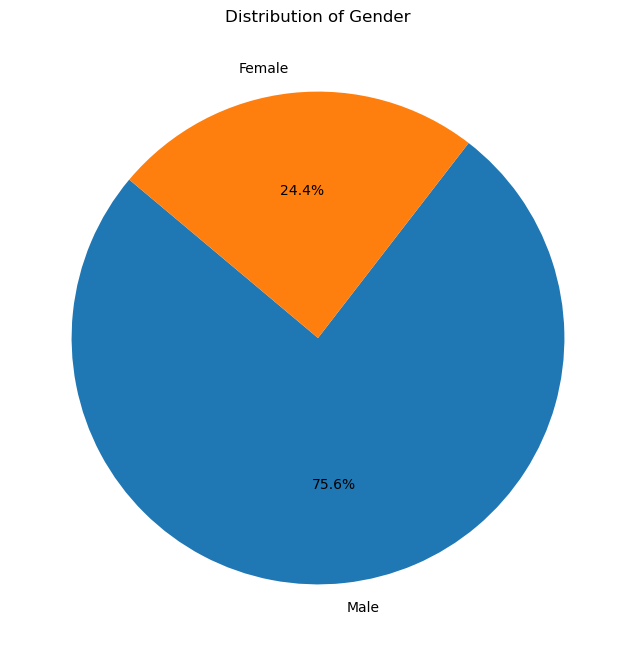

In [6]:
# 绘制 Gender 的饼状图
gender_counts = df['Gender'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Gender')
plt.show()

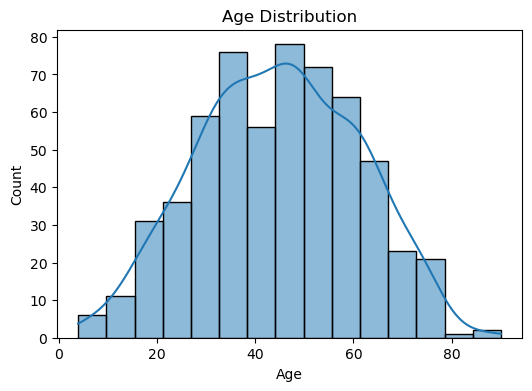

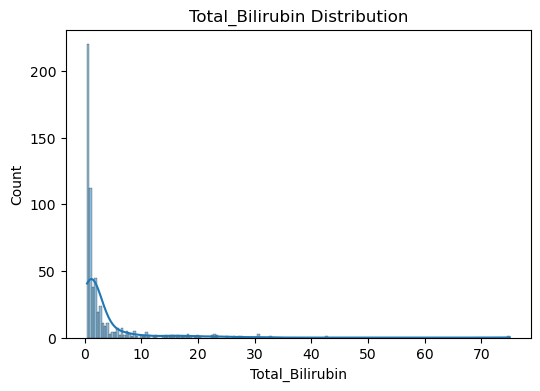

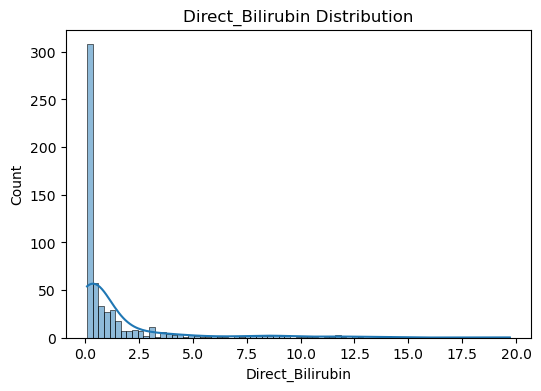

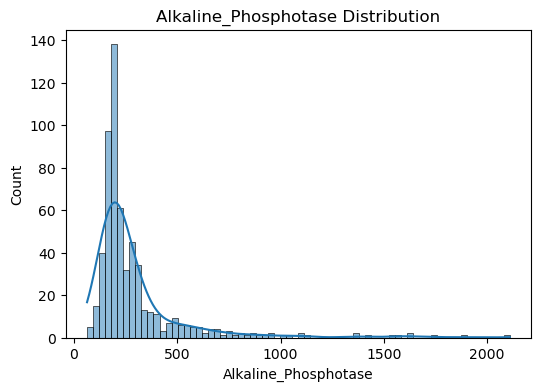

In [7]:
# 挑选重要特征并绘制饼状图、曲线图和分布图
important_features = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase']
for feature in important_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[feature], kde=True)
    plt.title(f'{feature} Distribution')
    plt.show()

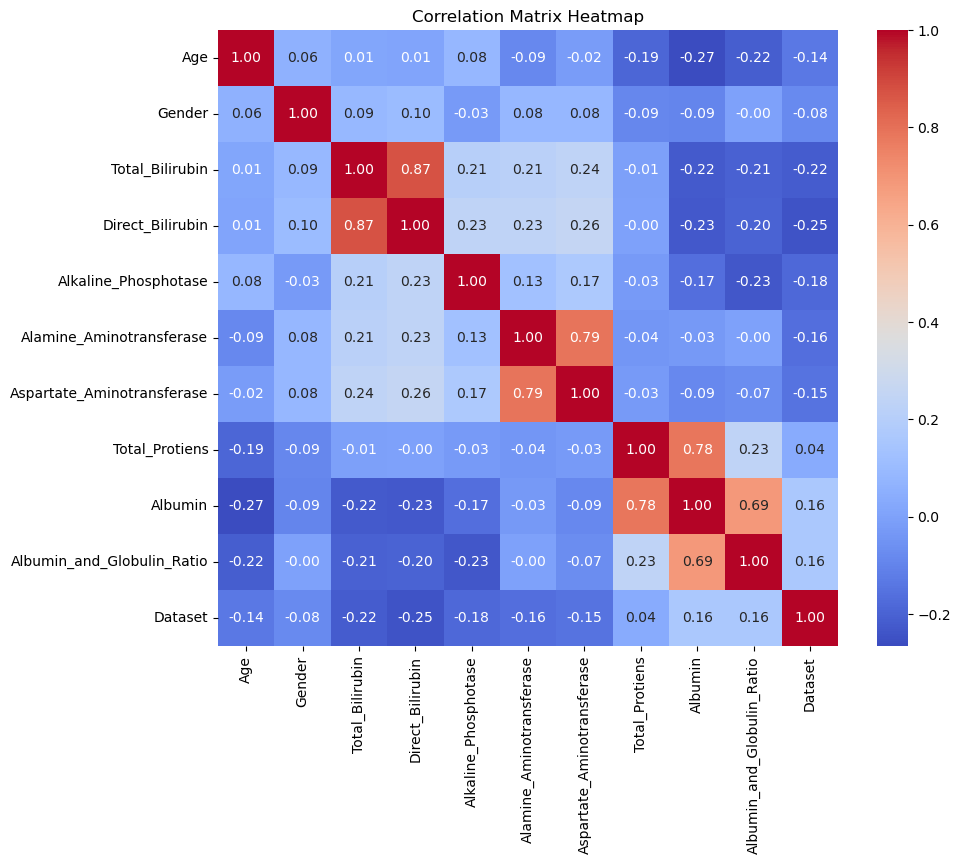

In [8]:
# 热力图
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

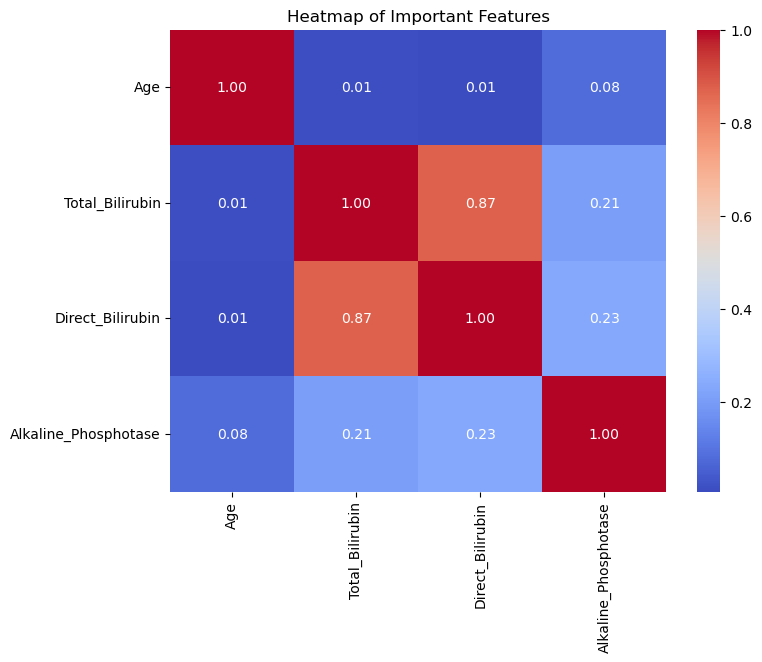

In [9]:
# 重要特征的详细热力图
plt.figure(figsize=(8, 6))
sns.heatmap(df[important_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Important Features')
plt.show()

# **构建模型**

In [10]:
# 构建模型
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

In [11]:
# 参数调优
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    },
    'K-Nearest Neighbors': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Support Vector Machine': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [50, 100, 200]
    }
}

best_models = {}

In [12]:
# 对每个模型进行参数调优
#对每个模型进行参数调优 通过网格搜索（Grid Search）参数调优  创建一个GridSearchCV对象，该对象用于执行网格搜索以找到最佳的超参数组合
for model_name, model in models.items():
    param_grid = param_grids[model_name]
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for K-Nearest Neighbors: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for Support Vector Machine: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}


In [13]:
# 模型评估
results = {}

for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    results[model_name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'AUC': auc
    }

    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    if auc:
        print(f"AUC: {auc:.4f}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=1))
    print("\n")

Model: Logistic Regression
Accuracy: 0.7436
F1 Score: 0.8529
Precision: 0.7436
AUC: 0.7962
[[ 0 30]
 [ 0 87]]
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        30
           1       0.74      1.00      0.85        87

    accuracy                           0.74       117
   macro avg       0.87      0.50      0.43       117
weighted avg       0.81      0.74      0.63       117



Model: K-Nearest Neighbors
Accuracy: 0.7009
F1 Score: 0.8023
Precision: 0.7889
AUC: 0.6989
[[11 19]
 [16 71]]
              precision    recall  f1-score   support

           0       0.41      0.37      0.39        30
           1       0.79      0.82      0.80        87

    accuracy                           0.70       117
   macro avg       0.60      0.59      0.59       117
weighted avg       0.69      0.70      0.70       117



Model: Support Vector Machine
Accuracy: 0.7436
F1 Score: 0.8529
Precision: 0.7436
AUC: 0.7548
[[ 0 30]
 [ 0 87]]
         

In [14]:
# 比较结果
results_df = pd.DataFrame(results).T
print("Model Evaluation Results:")
print(results_df)

Model Evaluation Results:
                        Accuracy  F1 Score  Precision       AUC
Logistic Regression     0.743590  0.852941   0.743590  0.796169
K-Nearest Neighbors     0.700855  0.802260   0.788889  0.698851
Support Vector Machine  0.743590  0.852941   0.743590  0.754789
Random Forest           0.726496  0.826087   0.783505  0.811494
XGBoost                 0.743590  0.852941   0.743590  0.788123


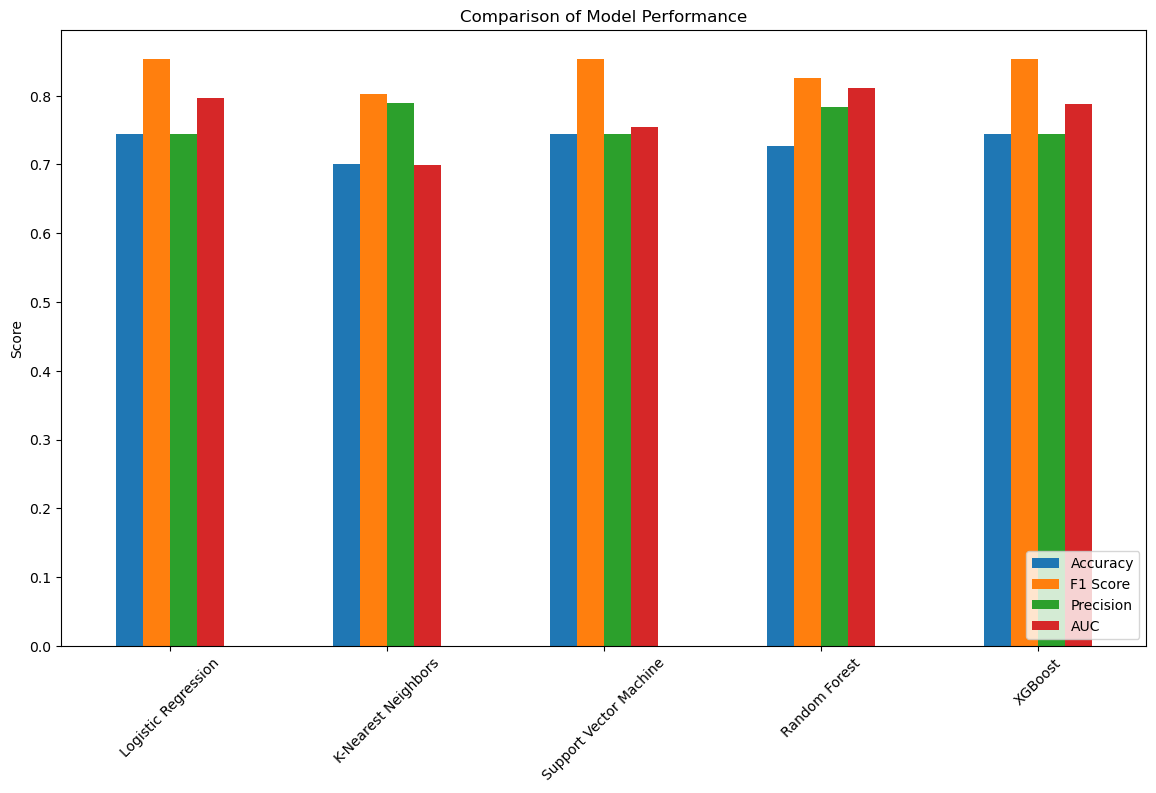

In [15]:
# 可视化模型性能比较
results_df.plot(kind='bar', figsize=(14, 8))
plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()